# Plots for section 5

In [57]:
#TODO: Try to replicate some plots from Ruhnau Paper (have another look at it)

### Imports

In [58]:
import pandas as pd
import matplotlib
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
from datetime import datetime
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors

from utils import market_values, market_values_links, market_values_by_time_index, market_values_links_con, congestion_rent_link, convert_ISO_3166_2_to_1, generation, generation_links, market_values_storage_units, generation_storage_units

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, capacity_storage_units, get_condense_sum

# imported own definitions
from utils import carrier_colors, carrier_renaming, resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [59]:
# Network imports
stst =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
exp =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [60]:
# Notebook Definitions

c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]

In [61]:
# Notebook Functions

def get_df(df_no, df_h2, carriers):
    result = pd.DataFrame(index = ["no H2 network", "H2 network"])

    for c in carriers:
        result.loc["no H2 network" , c] = df_no[c].values
        result.loc["H2 network" , c] = df_h2[c].values
    return result

In [62]:
# Regions

onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

### General
- round trip efficiency of hydrogen and batter storage (grafik mit power point machen) strom -> electrolyse -> storage -> fuel cell -> strom


### Network

In [63]:
l_h2 = exp.copy()

locs = l_h2.buses[l_h2.buses.carrier == "AC"][["x","y"]]
mapping = pd.DataFrame(l_h2.buses[l_h2.buses.carrier == "H2"].location)
mapping["bus"] = mapping.index
mapping.set_index("location", inplace =True)
locs.index = locs.index.map(mapping.to_dict()['bus'])
l_h2.buses.x[l_h2.buses.carrier == "H2"] = locs.x
l_h2.buses.y[l_h2.buses.carrier == "H2"] = locs.y

l_h2.mremove("Bus",l_h2.buses[l_h2.buses.carrier != "H2"].index)

# write LineStrign into pipes (links)
h2_pipes = l_h2.links[l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index
other_links = l_h2.links[-l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index

for pipe in h2_pipes:
    loc1 = l_h2.buses.loc[l_h2.links.loc[pipe].bus0][["x", "y"]]
    loc2 = l_h2.buses.loc[l_h2.links.loc[pipe].bus1][["x", "y"]]
    l_h2.links.geometry.loc[pipe] = LineString([Point(loc1), Point(loc2)]).wkt

l_h2.mremove("Link", other_links)
l_h2.mremove("Line", l_h2.lines.index)

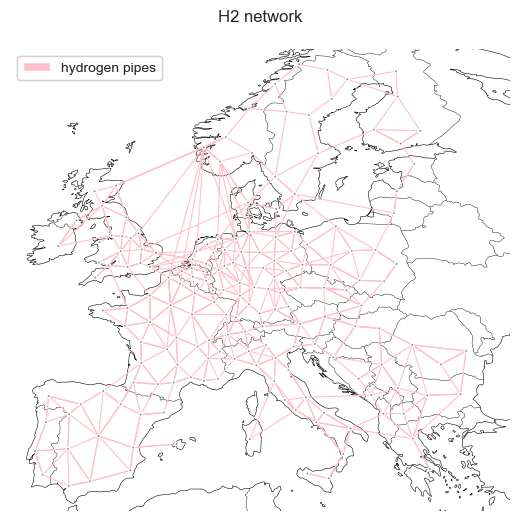

In [64]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

l_h2.plot(ax=ax, link_colors="pink", link_widths=0.8,  projection=ccrs.EqualEarth())
pypsa.plot.add_legend_patches(ax=ax, labels=["hydrogen pipes"], colors=["pink"], legend_kw={'loc': 'upper left'})
ax.set_title("H2 network", pad=20)
plt.show()

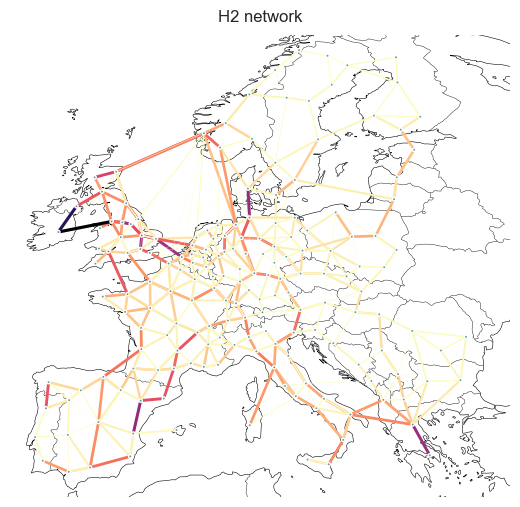

In [65]:
# adding colorbar to this

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

l_h2.links.p_max_pu
l_h2.plot(ax=ax, link_colors=l_h2.links.p_nom_opt, link_cmap=plt.get_cmap("magma_r"), link_widths=np.log10(l_h2.links.p_nom_opt)/2,  projection=ccrs.EqualEarth())
ax.set_title("H2 network", pad=10)
plt.show()

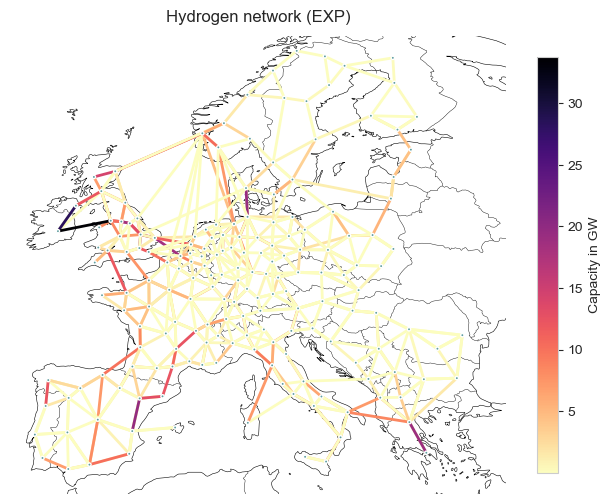

In [66]:
# with colorbar

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

# GW
link_loading = l_h2.links.p_nom_opt / 1000

cmap= plt.cm.magma_r
norm = mcolors.Normalize(vmin=link_loading.min(), vmax=link_loading.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
colors = list(map(mcolors.to_hex, cmap(norm(link_loading))))

l_h2.plot(ax=ax, link_colors=colors, link_widths=2,  projection=ccrs.EqualEarth())
plt.colorbar(sm, orientation='vertical', shrink=0.9, ax=ax, label="Capacity in GW")
plt.title("Hydrogen network (EXP)", pad=10)

plt.show()

In [67]:
# hydrogen pipeline network in km
exp.links[exp.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].length.sum()

193545.8096976719

In [68]:
exp.links[exp.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_max,p_nom_opt,charger_ratio,type,build_year,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
H2 pipeline retrofitted AL0 0 -> IT0 10,AL0 0 H2,IT0 10 H2,H2 pipeline retrofitted,,254.011781,0.0,INET_PL_669_EE_0_Seg_0_Seg_0_Seg_0,NaN,NaN,-1.0,...,7191.712500,7191.281817,NaN,,0,0.0,1.0,1.0,NaN,NaN
H2 pipeline retrofitted AT0 0 -> AT0 2,AT0 0 H2,AT0 2 H2,H2 pipeline retrofitted,,228.454388,0.0,PLS_6292_Seg_0_Seg_0,NaN,NaN,-1.0,...,900.000000,648.098650,NaN,,0,0.0,1.0,1.0,NaN,NaN
H2 pipeline retrofitted AT0 0 -> HU0 0,AT0 0 H2,HU0 0 H2,H2 pipeline retrofitted,,274.453912,0.0,ST_929_Seg_0_Seg_0_Seg_1 PLS_4606_Seg_0_Seg_0_...,NaN,NaN,-1.0,...,4435.636537,73.416337,NaN,,0,0.0,1.0,1.0,NaN,NaN
H2 pipeline retrofitted AT0 0 -> SK0 0,AT0 0 H2,SK0 0 H2,H2 pipeline retrofitted,,372.071027,0.0,EntsoG_Map__ST_423_Seg_0,NaN,NaN,-1.0,...,900.000000,4.860707,NaN,,0,0.0,1.0,1.0,NaN,NaN
H2 pipeline retrofitted AT0 0 <-> AT0 2,AT0 0 H2,AT0 2 H2,H2 pipeline retrofitted,,228.454388,0.0,PLL_709_Seg_0_Seg_0_Seg_3,NaN,NaN,-1.0,...,5604.826830,972.859923,NaN,,0,0.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H2 pipeline SE3 1 -> SE3 7,SE3 1 H2,SE3 7 H2,H2 pipeline,,272.988128,0.0,,NaN,NaN,-1.0,...,inf,187.565207,NaN,,0,0.0,1.0,1.0,NaN,NaN
H2 pipeline SE3 2 -> SE3 5,SE3 2 H2,SE3 5 H2,H2 pipeline,,141.983342,0.0,,NaN,NaN,-1.0,...,inf,458.127155,NaN,,0,0.0,1.0,1.0,NaN,NaN
H2 pipeline SE3 3 -> SE3 6,SE3 3 H2,SE3 6 H2,H2 pipeline,,222.522966,0.0,,NaN,NaN,-1.0,...,inf,2.193092,NaN,,0,0.0,1.0,1.0,NaN,NaN


In [69]:
stst.links[stst.links.carrier == "H2 Electrolysis"].efficiency.unique() # Electrolysis: 68 % efficiency
stst.links[stst.links.carrier == "H2 Fuel Cell"].efficiency.unique() # Fuel Cell: 50 % efficiency
stst.links[stst.links.carrier == "battery charger"].efficiency.unique() # Fuel Cell: 0.979796 efficiency
stst.links[stst.links.carrier == "battery discharger"].efficiency.unique() # Fuel Cell: 0.979796 efficiency

# storage losses?

array([0.9797959])

![](../../../../Pictures/Screenshots/Screenshot_20230219_110123.png)
Colbertado

### Capacity

In [70]:
cap_no = pd.DataFrame(index=stst.buses.location.unique())
cap_h2 = pd.DataFrame(index=exp.buses.location.unique())

for n, df in zip([stst, exp], [cap_no,cap_h2]):

    for c in n.generators.carrier.unique():
        # capacity in GW
        df[c] = capacity(n, c) / 1000

    for c in n.links.carrier.unique():
        # capacity in GW
        df[c] = capacity_links(n, c) / 1000

    for c in n.storage_units.carrier.unique():
        # capacity in GW
        df[c] = capacity_storage_units(n, c) / 1000

# condense groups
cap_no = get_condense_sum(cap_no, c1_groups, c1_groups_name)
cap_h2 = get_condense_sum(cap_h2, c1_groups, c1_groups_name)
# rename unhandy column names
cap_no.rename(columns=carrier_renaming, inplace=True)
cap_h2.rename(columns=carrier_renaming, inplace=True)
# take sum
cap_no_sum = pd.DataFrame(cap_no.sum().sort_values(ascending=False)).transpose()
cap_h2_sum = pd.DataFrame(cap_h2.sum().sort_values(ascending=False)).transpose()

In [71]:
# electrolyzer capcity
carriers = ["H2 Electrolysis"]
get_df(cap_no_sum, cap_h2_sum, carriers)

,H2 Electrolysis
no H2 network,1290.869609
H2 network,1082.971374


In [72]:
# H2 storage capcity
index_h2stores_no = stst.stores[stst.stores.carrier == "H2"].index

In [73]:
stst.stores[stst.stores.carrier == "H2"]

,bus,carrier,e_nom_extendable,e_cyclic,capital_cost,e_initial,e_min_pu,e_nom,e_nom_max,lifetime,...,e_nom_opt,type,e_nom_min,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
DE0 0 H2 Store,DE0 0 H2,H2,True,True,140.161529,0.0,0.0,0.0,3.257629e+06,inf,...,5.008064e+05,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 11 H2 Store,DE0 11 H2,H2,True,True,140.161529,0.0,0.0,0.0,3.464642e+08,inf,...,1.257958e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 15 H2 Store,DE0 15 H2,H2,True,True,140.161529,0.0,0.0,0.0,8.861846e+08,inf,...,1.833548e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 21 H2 Store,DE0 21 H2,H2,True,True,140.161529,0.0,0.0,0.0,2.866523e+07,inf,...,1.258530e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 23 H2 Store,DE0 23 H2,H2,True,True,140.161529,0.0,0.0,0.0,1.576804e+08,inf,...,5.705198e+05,,0.0,1.0,False,True,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 H2 Store,SE3 5 H2,H2,True,True,4117.636382,0.0,0.0,0.0,inf,inf,...,8.884398e+02,,0.0,1.0,False,True,0.0,0.0,1.0,0
SE3 6 H2 Store,SE3 6 H2,H2,True,True,4117.636382,0.0,0.0,0.0,inf,inf,...,1.235597e+03,,0.0,1.0,False,True,0.0,0.0,1.0,0
SE3 7 H2 Store,SE3 7 H2,H2,True,True,4117.636382,0.0,0.0,0.0,inf,inf,...,5.896688e+02,,0.0,1.0,False,True,0.0,0.0,1.0,0


In [74]:
# Optimised nominal energy capacity outputed by OPF.
df = stst.stores.e_nom_opt[index_h2stores_no]
df.index = df.index.map(stst.stores.bus).map(stst.buses.location)
onshore_regions["h2_cap_no"] = df

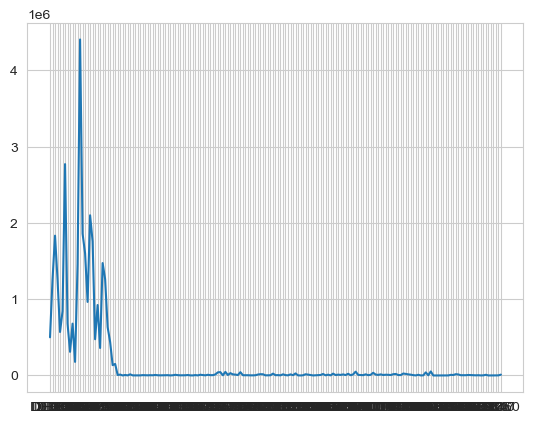

In [75]:
plt.plot(df)

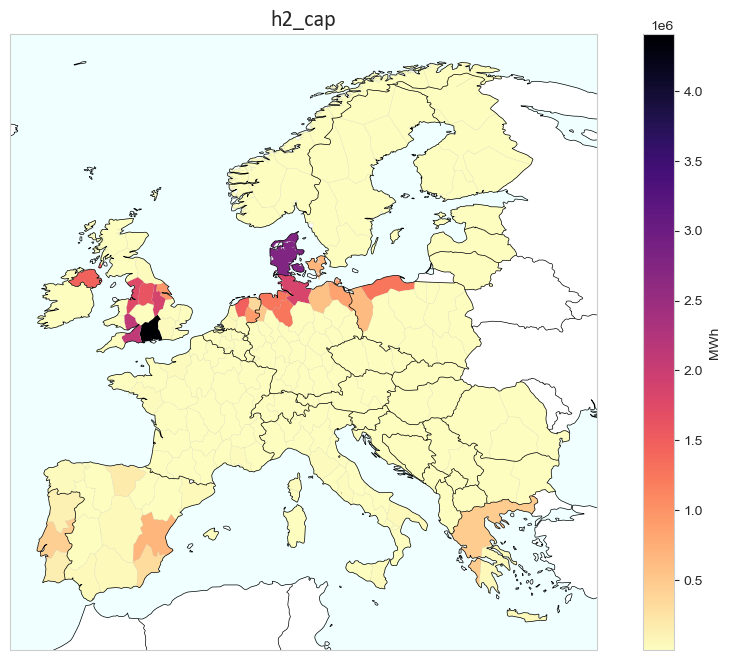

In [76]:
fig = plt.figure(figsize=(12, 8))
crs = ccrs.EqualEarth()

ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title("h2_cap", fontsize=16, **font1)

onshore_regions.to_crs(crs.proj4_init).plot(column="h2_cap_no",
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"MWh",
                        'orientation': "vertical"})

plt.show()

In [77]:
# Why are the hydrogen capacities located there?
# calc Correlation with wind, solar and other power plant capacity (e.g.

### Generation and Consumption

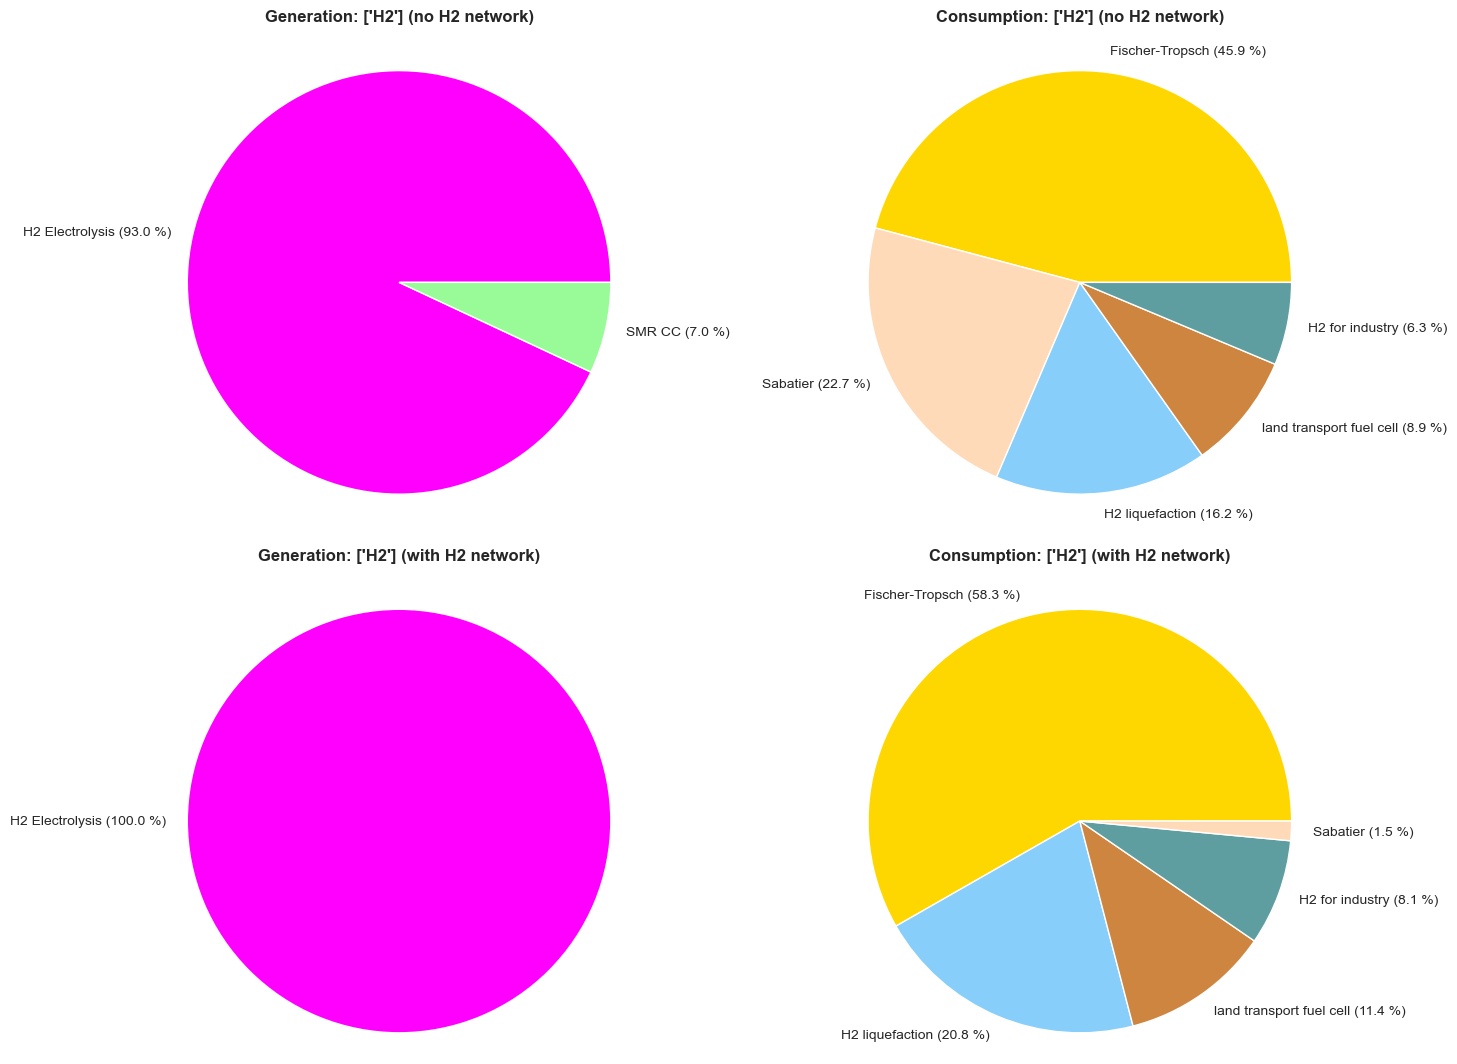

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["H2"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/5.1_hydrogen_overview/gen_con_hydrogen.png")

### Generation

In [79]:
# how long are the electrolyzers running
# load duration curve
# capacity factors
# pie chart of which electricity (from which source?) is used for electrolysers (is that possible)

![](../../../../Pictures/Screenshots/Screenshot_20230215_163455.png)

In [80]:
# get generation of all carriers
gen_stst = pd.DataFrame(index=stst.generators_t.p.index)
gen_exp = pd.DataFrame(index=exp.generators_t.p.index)

for n, gen in zip([stst, exp], [gen_stst, gen_exp]):

    for carrier in n.generators.carrier.unique():
        gen[carrier]= n.generators_t.p.loc[:, n.generators.carrier == carrier].mean(axis=1)

    for carrier in n.links.carrier.unique():
        gen[carrier]= abs(n.links_t.p1.loc[:, n.links.carrier == carrier]).mean(axis=1)

    for carrier in n.storage_units.carrier.unique():
        gen[carrier]= n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier].mean(axis=1)

gen_stst.head()
gen_exp.head()

,offwind-ac,onwind,solar,ror,offwind-dc,gas,residential rural solar thermal,services rural solar thermal,residential urban decentral solar thermal,services urban decentral solar thermal,...,H2 liquefaction,Fischer-Tropsch,process emissions,process emissions CC,DAC,electricity distribution grid,home battery charger,home battery discharger,hydro,PHS
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,268.143083,5551.771185,0.000000,131.480149,1923.417507,42693.291964,0.000000,0.000000,0.000000,0.000000,...,317.139904,649.639484,0.002220,1576.712107,0.002791,3663.660671,0.080187,0.078689,165.861003,-39.680649
2013-01-01 03:00:00,204.310567,5229.187357,0.000000,131.814111,1728.979883,42737.576537,0.000000,0.000000,0.000000,0.000000,...,317.139904,649.639501,0.002212,1576.712108,0.002648,3714.621554,0.077781,0.081399,166.498494,25.564299
2013-01-01 06:00:00,208.301047,4918.666102,693.716771,133.240706,2045.517347,42809.069444,0.000010,0.000009,0.000016,0.000014,...,317.139904,649.639476,0.002210,1576.712108,0.002701,4096.516148,0.079776,0.079938,4.149153,-203.035320
2013-01-01 09:00:00,192.722434,4370.152534,3400.242546,135.214357,2282.299700,42837.916349,0.002005,0.001966,0.002839,0.002707,...,317.139904,649.639559,0.002207,1576.712108,0.002841,4350.784532,0.086951,0.073144,4.129062,-563.707456
2013-01-01 12:00:00,198.327351,4309.124022,2756.980878,138.019046,2510.954302,42911.830920,0.002984,0.002702,0.005925,0.004024,...,317.139904,649.639437,0.002201,1576.712109,0.002847,4216.609612,0.088634,0.071517,4.319208,-439.550813


<Figure size 1000x600 with 0 Axes>

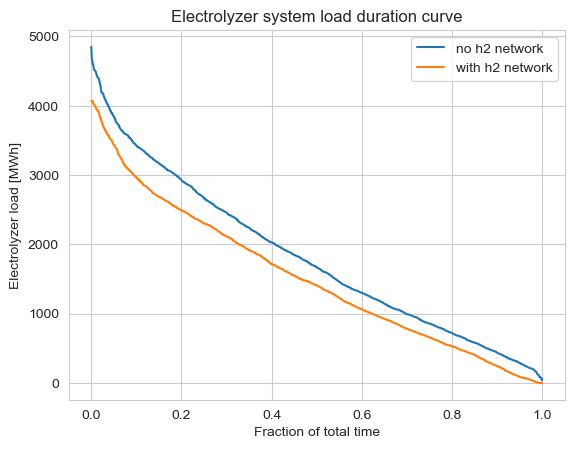

In [81]:
# why is this in a whole other magnitude than capacity?
# does sorting the whole df make sense? shouldtn the be sorted seperately?

df = pd.DataFrame(gen_stst["H2 Electrolysis"].sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
df["H2 Electrolysis no h2"] = pd.DataFrame(gen_exp["H2 Electrolysis"].sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
df.columns = ["no h2 network","with h2 network" ]

plt.figure(figsize=(10, 6))
df.plot()
plt.title("Electrolyzer system load duration curve")
plt.ylabel("Electrolyzer load [MWh]")
plt.xlabel("Fraction of total time")
plt.legend()
plt.show()

## Balance Flow

In [82]:
l_h2 = exp.copy()

locs = l_h2.buses[l_h2.buses.carrier == "AC"][["x","y"]]
mapping = pd.DataFrame(l_h2.buses[l_h2.buses.carrier == "H2"].location)
mapping["bus"] = mapping.index
mapping.set_index("location", inplace =True)
locs.index = locs.index.map(mapping.to_dict()['bus'])
l_h2.buses.x[l_h2.buses.carrier == "H2"] = locs.x
l_h2.buses.y[l_h2.buses.carrier == "H2"] = locs.y

l_h2.mremove("Bus",l_h2.buses[l_h2.buses.carrier != "H2"].index)

# write LineStrign into pipes (links)
h2_pipes = l_h2.links[l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index
other_links = l_h2.links[-l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index

for pipe in h2_pipes:
    loc1 = l_h2.buses.loc[l_h2.links.loc[pipe].bus0][["x", "y"]]
    loc2 = l_h2.buses.loc[l_h2.links.loc[pipe].bus1][["x", "y"]]
    l_h2.links.geometry.loc[pipe] = LineString([Point(loc1), Point(loc2)]).wkt

l_h2.mremove("Link", other_links)
l_h2.mremove("Line", l_h2.lines.index)

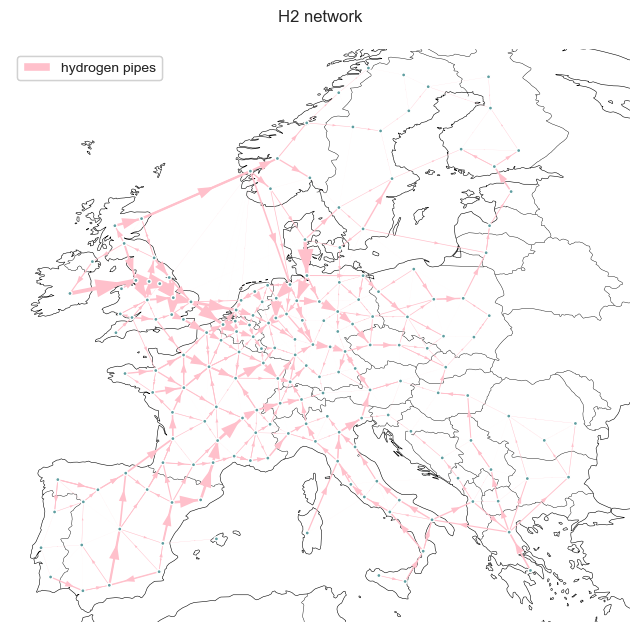

In [83]:
# Hydrogen network
# link_cmap=plt.get_cmap("magma_r")

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8))

l_h2.plot(ax=ax, link_colors="pink", link_widths=2e-5,  flow="sum", projection=ccrs.EqualEarth())
pypsa.plot.add_legend_patches(ax=ax, labels=["hydrogen pipes"], colors=["pink"], legend_kw={'loc': 'upper left'})
ax.set_title("H2 network", pad=20)
plt.show()

### Storage Behavior

#### Feed-in and feed-out pattern

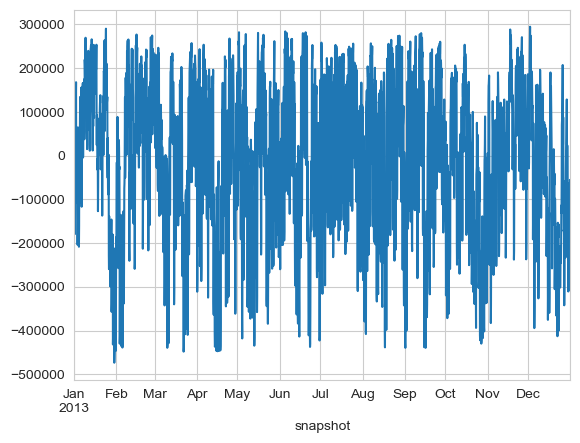

In [84]:
# Energy as calculated by the OPF.
index_h2stores = stst.stores[stst.stores.carrier == "H2"].index

n.stores_t.p[index_h2stores].sum(axis=1).plot()
plt.show()

#### Storage level over time

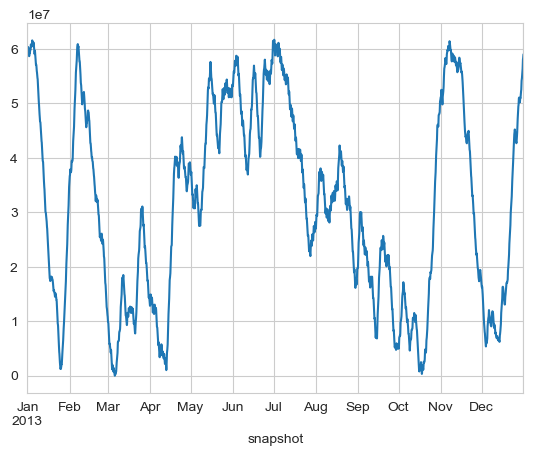

In [85]:
# Energy as calculated by the OPF.
n.stores_t.e[index_h2stores].sum(axis=1).plot()
plt.show()

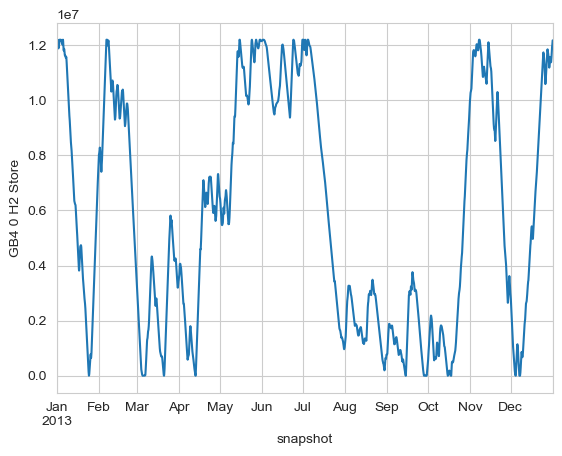

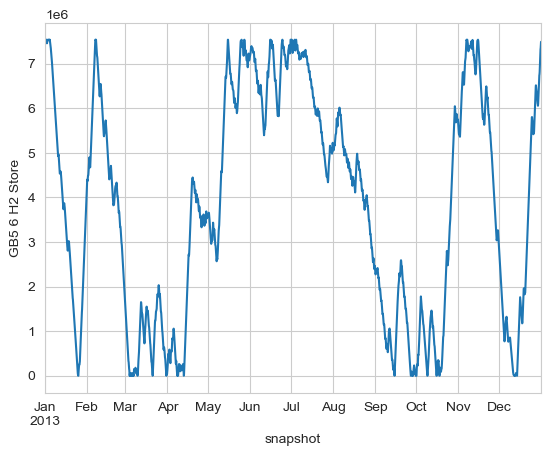

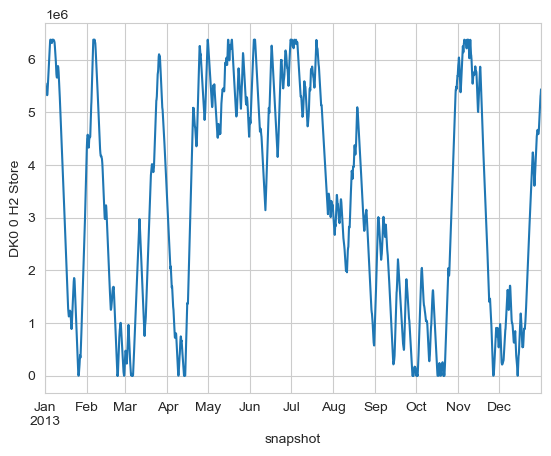

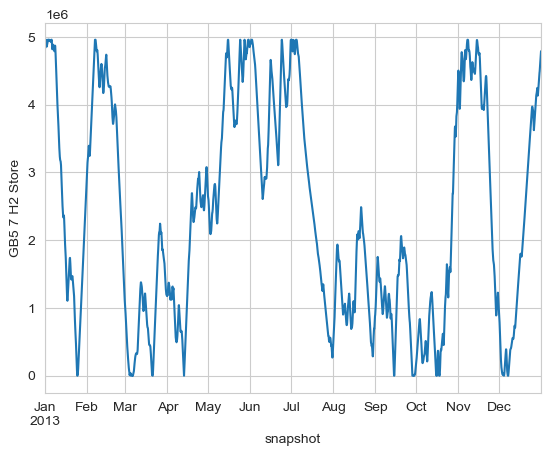

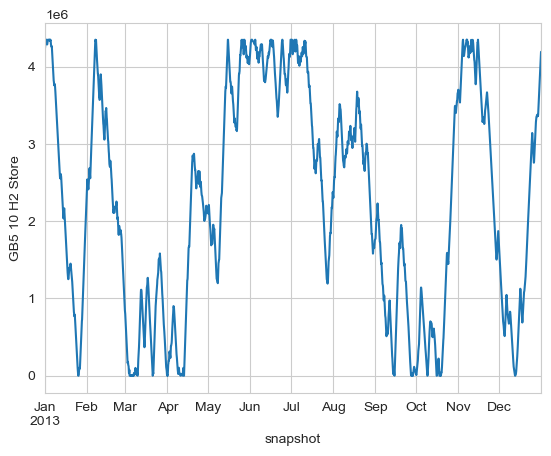

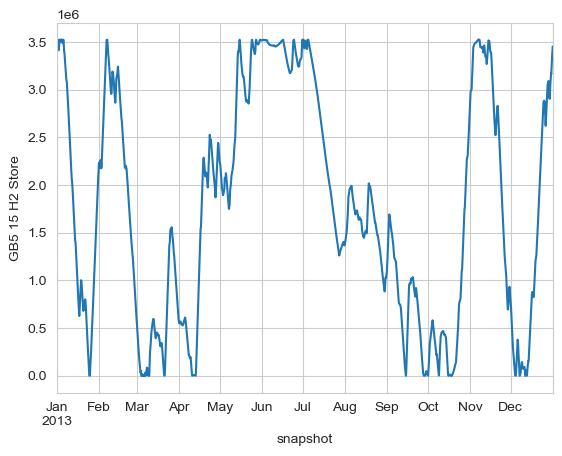

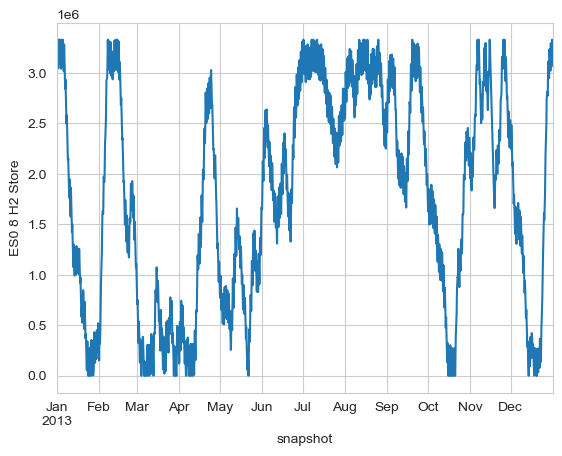

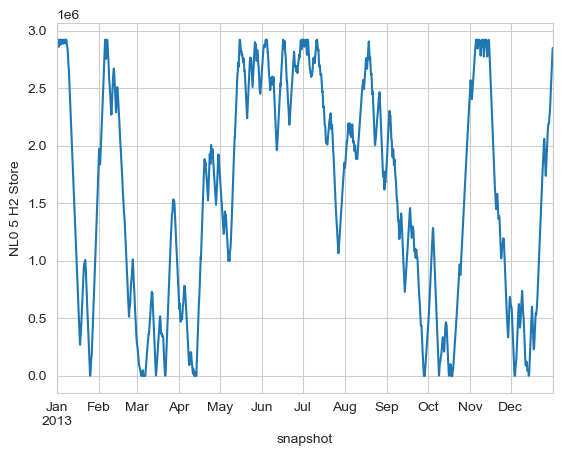

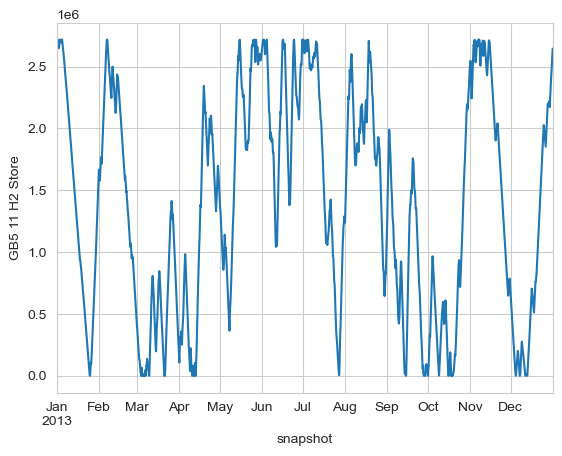

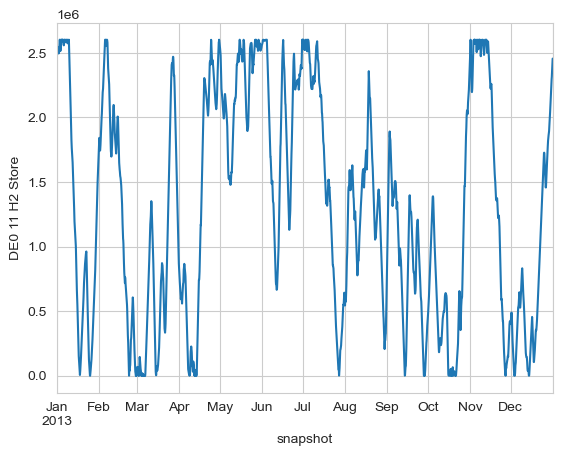

In [86]:
# storage level of 10 largest stores
index = n.stores.e_nom_opt[index_h2stores].sort_values(ascending=False).head(10).index

# yearly plot
for store in index:
    fig, ax = plt.subplots()
    n.stores_t.e[store].plot(ax=ax, ylabel=store)

## Ideas:
- Calc capacity factors / system load duration curves for electrolysis in different regions and try to investigate in differences (amount of wind generation, solar) Is only excess electrolysis consumed by electrolysis?
- Try to determine connection between electrolysis and excess solar / wind production
- Try to determine percent / amount of excess electricity that is used to produce hydrogen. (Basically all energy from renewables that went into electrolysis?)
- pie chart of percentage of electricity that is used directly, used for Electrolysis, battery, ... (startup script)
- Reproduce graph from Victoria, Zhu et al. 2019 – The role of storage technologies (in hydrogen word document); try to find patterns within the charging of battery and the charging with hydrogen (electrolysis -> fuel cell)
-